In [88]:
from pathlib import Path
from enum import Enum
import cv2
from cv2 import imwrite
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from time import time
from scipy.optimize import curve_fit
%matplotlib inline
import scipy.stats
from util import parse_fn, is_bg
from scipy import stats
from scipy.stats import skewnorm
from scipy.special import erf
from scipy.special import voigt_profile
import re

## information of picture

In [99]:
HEADER_LEN = 152 
X_DIM = 1200 
Y_DIM = 1920
X_left_boundry = 550
X_right_boundry = 650
Y_left_boundry = 975
Y_right_boundry = 1170

## picture to blue light signal intensity

In [100]:
def read_raw_to_intensity(file):
    
    with open(file, "rb") as rawimage:
    
        bayer_image = np.fromfile(rawimage, np.dtype('u1'), offset = HEADER_LEN)
        fst_byte, scd_byte = bayer_image.reshape((bayer_image.shape[0]//2, 2)).astype(np.uint16).T
        raw_pixel = (fst_byte + (scd_byte << 8)).reshape((X_DIM, Y_DIM))

    return raw_pixel


def intensity_to_blue_16(intensity):
    intensity_uint16 = np.array(intensity, dtype = np.uint16)
    color = cv2.cvtColor(intensity_uint16, cv2.COLOR_BayerGRBG2RGB)
    blue = color[:,:,2]
    return blue


def get_blue(file):
    raw_pixel = read_raw_to_intensity(file)
    blue = intensity_to_blue_16(raw_pixel)
    return blue.astype(np.float64)

## Input here: get the bright region

In [101]:
def get_bright(pure_blue):
    data = pure_blue[X_left_boundry:X_right_boundry, Y_left_boundry:Y_right_boundry]
    return data

## get blue signal of interested region : get_data(file)

In [102]:
# 拿到我要的範圍的blue
def get_data(file):
    blue = get_blue(file)
    bright = get_bright(blue)
    return bright

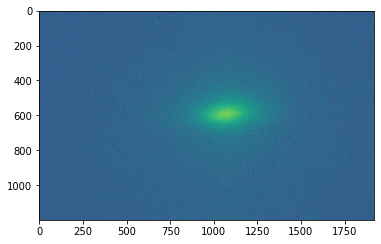

In [103]:
a = get_blue("/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_2/45mm_per_sec/10mm_37W_007.raw")
b = get_bright(a)
c = get_blue("/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_2/45mm_per_sec/10mm_0W_3_007.raw")
d = get_bright(c)
plt.imshow(a-c)

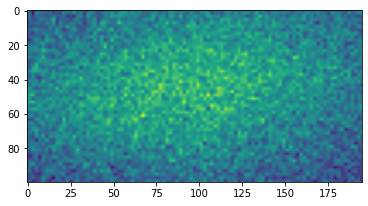

In [104]:
plt.imshow(b-d)

## get final fitting peak dR / R (one value) of a frame

In [78]:
def peak_dRoverR(file, b_file, func, maxs_func):
    dRoverR = get_dRoverR(file, b_file)
    maxs = get_maxs(dRoverR, func)
    peak = get_max(maxs, maxs_func)
    return peak

In [77]:
def get_peak_dRoverR(file, back_intensity, func, maxs_func):
    dRoverR = get_dR_over_R(file, back_intensity)
    maxs = get_maxs(dRoverR, func)
    peak = get_max(maxs, maxs_func)
    return peak

## get dR / R of every point of interested in a frame

In [76]:
def get_dRoverR(file, b_file):
    blue = get_data(file)
    b_blue = get_data(b_file)
    dRoverR = (blue - b_blue) / b_blue
    return dRoverR

In [75]:
def get_dR_over_R(file, back_intensity):
    blue = get_data(file)
    b_blue = get_bright(back_intensity)
    dRoverR = (blue - b_blue) / b_blue
    return dRoverR